# Practice Project 1 - Uber Fare Prediction
### DESCRIPTION

### Project Objective: 
Design an algorithm which will tell the fare to be charged for a passenger.

### Problem Statement Scenario: 
A fare calculator helps a customer in identifying the fare valid for the trip. They are often used by passengers who are new to a city or tourists to get an estimate of travel costs.<br>
You are provided with a dataset with features like fare amount, pickup and drop location, passenger count, and so on.
### Following actions should be performed:
    • Understand the type of data.
    • Identify the output variable.
    • Identify the factors which affect the output variable.
    • Check if there are any biases in your dataset.
    • Count the null values existing in columns.
    • Remove the null value rows in the target variable.
    • Perform train test split.
    • Predict the accuracy using regression models.
    • Check and compare the accuracy of the different models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, make_scorer
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV

##### It's a huge data set and hence we will use chunksize parameter in pd.read_csv get the data in chunks and then randomly extract 0.5% data from each chunk to form our training data set.

In [2]:
# Getting the training data in chunks

chunks = pd.read_csv (r'H:\Documents\Study material\Data Science course\Machine Learning\Main projects\Practice Project 1 - Uber Fare Prediction\train.csv', 
                  chunksize = 100000)

In [3]:
# Extracting 0.5% randomly selected rows from each chunk to form training data set

uber = pd.DataFrame ()

for chunk in chunks :
    size = chunk.shape[0]
    rand_rows = np.random.randint (0, size, int (size * 0.005))
    uber = uber.append (chunk.iloc [rand_rows])

display (uber.head ())

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
11072,2012-04-08 19:20:29.0000002,6.5,2012-04-08 19:20:29 UTC,-73.982366,40.762555,-73.992764,40.749534,1
12162,2014-05-13 07:36:00.00000068,12.0,2014-05-13 07:36:00 UTC,-73.996620,40.697470,-74.008070,40.722250,1
62129,2013-11-25 16:46:00.000000147,8.5,2013-11-25 16:46:00 UTC,-73.966052,40.765217,-73.975767,40.757342,1
36509,2009-08-24 07:21:56.0000002,6.5,2009-08-24 07:21:56 UTC,-73.998676,40.734641,-73.980908,40.759032,1
73089,2015-01-14 21:14:02.0000005,16.5,2015-01-14 21:14:02 UTC,-73.993362,40.735081,-73.955276,40.777012,1


In [4]:
# Saving the extracted data set to a file for reuse in the future

uber.to_csv (r'H:\Documents\Study material\Data Science course\Machine Learning\Main projects\Practice Project 1 - Uber Fare Prediction\train_ext.csv',
             index = False)

In [2]:
# Importing the extracted training data set

uber = pd.read_csv (r'H:\Documents\Study material\Data Science course\Machine Learning\Main projects\Practice Project 1 - Uber Fare Prediction\train_ext.csv')
print ('************************************************ Train data ************************************************')
display (uber.head (2))
print ('The shape of the data set =', uber.shape)

# Importing the testing data set

uber_test = pd.read_csv (r'H:\Documents\Study material\Data Science course\Machine Learning\Main projects\Practice Project 1 - Uber Fare Prediction\test.csv')
print ('\n\n************************************************ Test data ************************************************')
display (uber_test.head (2))
print ('The shape of the testing data set =', uber_test.shape)

************************************************ Train data ************************************************


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2012-04-08 19:20:29.0000002,6.5,2012-04-08 19:20:29 UTC,-73.982366,40.762555,-73.992764,40.749534,1
1,2014-05-13 07:36:00.00000068,12.0,2014-05-13 07:36:00 UTC,-73.996620,40.697470,-74.008070,40.722250,1


The shape of the data set = (277119, 8)


************************************************ Test data ************************************************


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1


The shape of the testing data set = (9914, 7)


In [3]:
# Understanding the training data types

uber.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277119 entries, 0 to 277118
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                277119 non-null  object 
 1   fare_amount        277119 non-null  float64
 2   pickup_datetime    277119 non-null  object 
 3   pickup_longitude   277119 non-null  float64
 4   pickup_latitude    277119 non-null  float64
 5   dropoff_longitude  277116 non-null  float64
 6   dropoff_latitude   277116 non-null  float64
 7   passenger_count    277119 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 16.9+ MB


##### Inferences:
    1. The training data has 8 columns and 277119 observations.
    2. The test data has 7 columns and 9914 observations.
    3. The fare_amount is the target variable which is present in the train data but not in test data.
    4. There are 2 object columns, 1 integer column and 5 float columns (including fare_column).
    5. The pickup_datetime column is object type has to converted to datatime type.
    6. We can see that there 3 missing values each in the columns dropoff_longitude and dropoff_latitude
       needs to be treated.
We can check if there are any missing values in the testing data.

In [4]:
# Checking the null values in the testing data

uber_test.isna ().sum ()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

##### There are no missing values in the testing data. We can drop the rows with the missing values.

In [5]:
# Dropping the rows with the missing values

uber.dropna (inplace = True)

In [6]:
# Converting the pickup_datetime to the required format

uber.pickup_datetime = pd.to_datetime (uber.pickup_datetime)
uber_test.pickup_datetime = pd.to_datetime (uber_test.pickup_datetime)
uber.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [7]:
# Getting the statistical summary of the data

print ('************************************************ Train data ************************************************')
display (uber.describe (include = 'all'))
print ('\n\n************************************************ Test data ************************************************')
display (uber_test.describe (include = 'all'))

************************************************ Train data ************************************************


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,277116,277116.000000,277116,277116.000000,277116.000000,277116.000000,277116.000000,277116.000000
unique,276461,NaN,269952,NaN,NaN,NaN,NaN,NaN
top,2011-02-15 14:19:00.00000077,NaN,2009-04-05 12:46:00+00:00,NaN,NaN,NaN,NaN,NaN
freq,3,NaN,4,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2009-01-01 00:10:41+00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2015-06-30 23:26:16+00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,11.341585,NaN,-72.481999,39.914381,-72.504710,39.927702,1.686893
std,NaN,9.782132,NaN,15.227166,11.375919,13.880864,12.256620,1.310315
min,NaN,-52.000000,NaN,-2139.911883,-3114.290742,-2941.480402,-2452.134608,0.000000
25%,NaN,6.000000,NaN,-73.992087,40.734922,-73.991430,40.734002,1.000000




************************************************ Test data ************************************************


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914,9914,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
unique,9914,1753,NaN,NaN,NaN,NaN,NaN
top,2009-02-28 10:19:41.0000001,2011-12-13 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN
freq,1,270,NaN,NaN,NaN,NaN,NaN
first,NaN,2009-01-01 11:04:24+00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,2015-06-30 20:03:50+00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,NaN,NaN,0.042774,0.033541,0.039072,0.035435,1.278747
min,NaN,NaN,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,NaN,NaN,-73.992501,40.736125,-73.991247,40.735254,1.000000


##### Inferences:
    1. Key has no relevance in modeling.
    2. We have column with pick up date and time. This can be of interest in analysing whether the following
       have any impact to the fare_amount :
           a. Day of the week (Specially the weekends)
           b. Pickup time (like morning, afternoon, evening or late night)
           c. Week number (certain festival weeks might see a surge in the fare amount.
    3. Since, we have pickup and dropoff locations, we can calculate the distance between these locations
       which may have a direct impact on the fare_amount variable.
    4. There are negative values in the fare amount which may be due to some refund.
       We would remove the negative values in the fare amount as they irrelevant for predictions.
    5. All location variables pickup longitude and latitude, dropoff longitude and latitude in the train data
       have values far above and below the Q1 and Q3 respectively and hence we would like the range to set
       same as test data.
    6. In the fare_amount column also we can see that the max value is far away from the Q3 which is unusual.
       We can explore the fare_amount column to see that can be done about it.
    7. The passenger count of 0 is also irrelevant.
    8. We can see the distributions of the all the variables to see the presence of outliers.

In [8]:
# Checking the rows in training data which are beyond the range of the test data

uber [ (uber.pickup_longitude < uber_test.pickup_longitude.min ()) |\
        (uber.pickup_longitude > uber_test.pickup_longitude.max ()) | \
        (uber.pickup_latitude < uber_test.pickup_latitude.min ()) | \
        (uber.pickup_latitude > uber_test.pickup_latitude.max ()) | \
        (uber.dropoff_longitude < uber_test.dropoff_longitude.min ()) | \
        (uber.dropoff_longitude > uber_test.dropoff_longitude.max ()) | \
        (uber.dropoff_latitude < uber_test.dropoff_latitude.min ()) | \
        (uber.dropoff_latitude > uber_test.dropoff_latitude.max ()) | \
        (uber.passenger_count < uber_test.passenger_count.min ()) | \
        (uber.passenger_count > uber_test.passenger_count.max ()) ]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
84,2012-12-26 22:40:00.00000022,5.50,2012-12-26 22:40:00+00:00,-73.998198,40.717752,0.000000,0.000000,2
86,2011-10-31 09:39:50.0000004,7.30,2011-10-31 09:39:50+00:00,-73.996200,40.763300,-74.004600,40.742100,0
209,2010-08-08 13:36:57.0000002,14.10,2010-08-08 13:36:57+00:00,0.000000,0.000000,0.000000,0.000000,1
268,2009-09-09 14:27:36.0000002,7.30,2009-09-09 14:27:36+00:00,0.000000,0.000000,0.000000,0.000000,1
280,2014-03-07 19:04:29.0000001,7.00,2014-03-07 19:04:29+00:00,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...
276900,2015-01-24 14:27:16.0000002,7.00,2015-01-24 14:27:16+00:00,0.000000,0.000000,0.000000,0.000000,2
277036,2012-01-21 19:03:03.0000001,6.90,2012-01-21 19:03:03+00:00,0.000000,0.000000,0.000000,0.000000,1
277104,2012-04-07 21:21:55.0000002,13.70,2012-04-07 21:21:55+00:00,-73.969563,40.760800,-74.003287,40.723915,0
277114,2012-11-16 00:54:00.00000037,56.80,2012-11-16 00:54:00+00:00,-73.985420,40.753342,0.000000,0.000000,6


##### Inferences:
    1. There are in total 6859 rows which are beyond the range of the test data.
    2. From the data of over 250000 rows it is safe to completely dropoff these rows.

In [9]:
# remove the rows in the train data which are beyond the range of the test data

uber = uber [ (uber.pickup_longitude >= uber_test.pickup_longitude.min ()) & \
              (uber.pickup_longitude <= uber_test.pickup_longitude.max ()) & \
              (uber.pickup_latitude >= uber_test.pickup_latitude.min ()) & \
              (uber.pickup_latitude <= uber_test.pickup_latitude.max ()) & \
              (uber.dropoff_longitude >= uber_test.dropoff_longitude.min ()) & \
              (uber.dropoff_longitude <= uber_test.dropoff_longitude.max ()) & \
              (uber.dropoff_latitude >= uber_test.dropoff_latitude.min ()) & \
              (uber.dropoff_latitude <= uber_test.dropoff_latitude.max ()) & \
              (uber.passenger_count >= uber_test.passenger_count.min ()) & \
              (uber.passenger_count <= uber_test.passenger_count.max ()) ]

print ('The shape of the training data =', uber.shape)

The shape of the training data = (270257, 8)


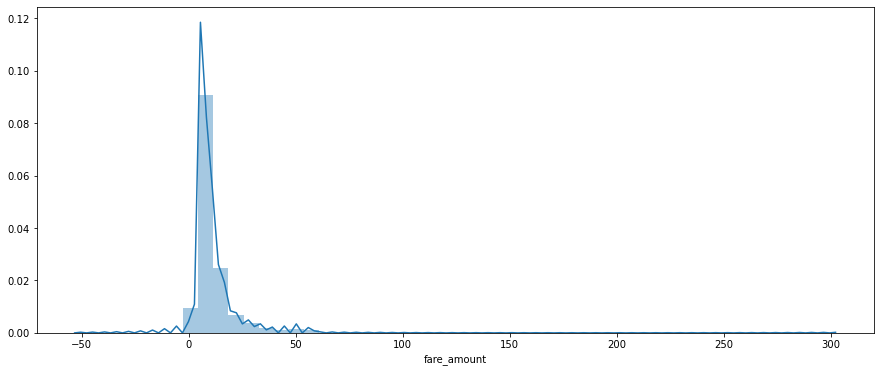

In [10]:
# Exploring the fare_amount column

plt.figure (figsize = (15,6))
sns.distplot (uber.fare_amount);

##### Inferences: 
    1. Looks like there are extreme outliers in the fare_amount and they might pose problem in modeling.
    2. But since, this a target variable, we cannot directly remove them. We must check the relationships
       with other variables and see if these are irrelevant data points.
    3. We check the scatterplot between distance and fare_amount and see the patterns.

In [11]:
# Creating the distance variable using pickup and dropoff latitude and longitude

def dist (x) :
    dis = distance ((x[3], x[2]), (x[1], x[0])).miles
    return (dis)

uber ['distance'] = uber.loc[:,'pickup_longitude':'dropoff_latitude'].copy ().apply (dist, axis = 1)
uber_test ['distance'] = uber_test.loc[:,'pickup_longitude':'dropoff_latitude'].copy ().apply (dist, axis = 1)

print ('************************************************ Train data ************************************************')
display (uber.head (2))
print ('\n\n************************************************ Test data ************************************************')
display (uber_test.head (2))

************************************************ Train data ************************************************


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2012-04-08 19:20:29.0000002,6.5,2012-04-08 19:20:29+00:00,-73.982366,40.762555,-73.992764,40.749534,1,1.051167
1,2014-05-13 07:36:00.00000068,12.0,2014-05-13 07:36:00+00:00,-73.996620,40.697470,-74.008070,40.722250,1,1.812493




************************************************ Test data ************************************************


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,1.442197
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,1.506080


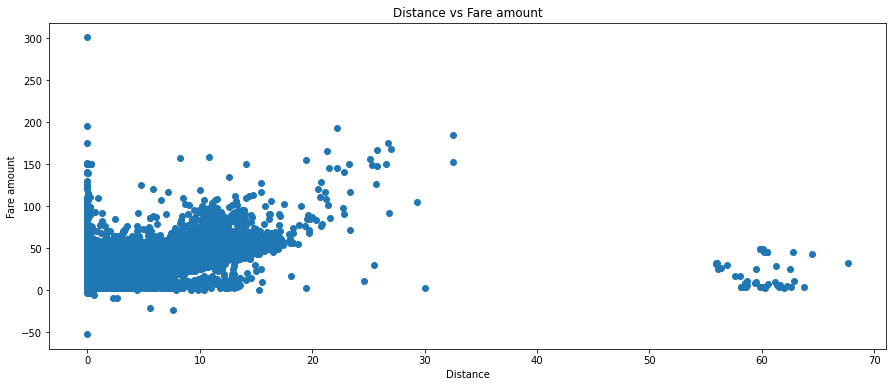

In [12]:
# Scatterplot between distance and fare_amount

plt.figure (figsize=(15,6))
plt.scatter (uber.distance, uber.fare_amount)
plt.xlabel ('Distance')
plt.ylabel ('Fare amount')
plt.title ('Distance vs Fare amount');

##### Inferences:
    1. In a data of over 2.5 lac observations looks like most of the data is concentrated at fare_amount of < 100.
    2. There are certain outliers in the distance variable too. Hence we can remove data points with distance > 35.
    3. We can see some negative values of fare_amount which we can remove.

In [13]:
# Checking the count of data point in the distance and fare_amount variable which might be noise
# Also checking negative values in fare_amount columns

print ('Count of data points where fare_amount is > 100 is', (uber.fare_amount > 100).sum ())
print ('\nNegative values in fare_amount column are:\n', uber [ uber.fare_amount <= 0 ].fare_amount.values)
print ('Count of rows =', uber [ uber.fare_amount <= 0 ].shape [0])
print ('\nCount of data points where distance is > 35 (in train data) = ', (uber.distance > 35).sum ())
print ('Count of data points where distance is > 35 (in test data) = ', (uber_test.distance > 35).sum ())

Count of data points where fare_amount is > 100 is 86

Negative values in fare_amount column are:
 [ -3.   -2.5   0.    0.    0.    0.    0.   -3.  -52.   -3.   -6.    0.
  -2.5  -3.3 -23.7  -5.   -9.7  -9.7   0.    0.   -3.3  -3.   -2.5 -20.5
   0.    0. ]
Count of rows = 26

Count of data points where distance is > 35 (in train data) =  43
Count of data points where distance is > 35 (in test data) =  3


Since the count of these data points are very less compared to the total, we can remove them considering them as noise.<br>
We can also remove the negative values of the fare_amount as these are irrelevant from the perspective of predictive modeling.

In [14]:
# Removing the noisy data points

uber = uber [(uber.fare_amount > 0) & (uber.fare_amount < 100) & (uber.distance < 30)]
print ('The shape of the resultant training data =', uber.shape)
uber_test = uber_test [uber_test.distance < 30]
print ('The shape of the resultant testing data =', uber_test.shape)

The shape of the resultant training data = (270096, 9)
The shape of the resultant testing data = (9911, 8)


In [15]:
# Extracting the weekday, week number and pick up hour from the pickup_datetime column

uber ['weeknum'] = uber.pickup_datetime.apply (lambda x : int (x.strftime ('%W')))
uber ['weekday'] = uber.pickup_datetime.apply (lambda x : x.weekday ())
uber ['pickup_hour'] = uber.pickup_datetime.apply (lambda x : x.hour)
uber ['month'] = uber.pickup_datetime.apply (lambda x : x.month)
uber ['year'] = uber.pickup_datetime.apply (lambda x : x.year)

uber_test ['weeknum'] = uber_test.pickup_datetime.apply (lambda x : int (x.strftime ('%W')))
uber_test ['weekday'] = uber_test.pickup_datetime.apply (lambda x : x.weekday ())
uber_test ['pickup_hour'] = uber_test.pickup_datetime.apply (lambda x : x.hour)
uber_test ['month'] = uber_test.pickup_datetime.apply (lambda x : x.month)
uber_test ['year'] = uber_test.pickup_datetime.apply (lambda x : x.year)

# Dropping the pickup_datetime column since we have already extracted all the useful information

uber.drop (columns = 'pickup_datetime', inplace = True)
uber_test.drop (columns = 'pickup_datetime', inplace = True)

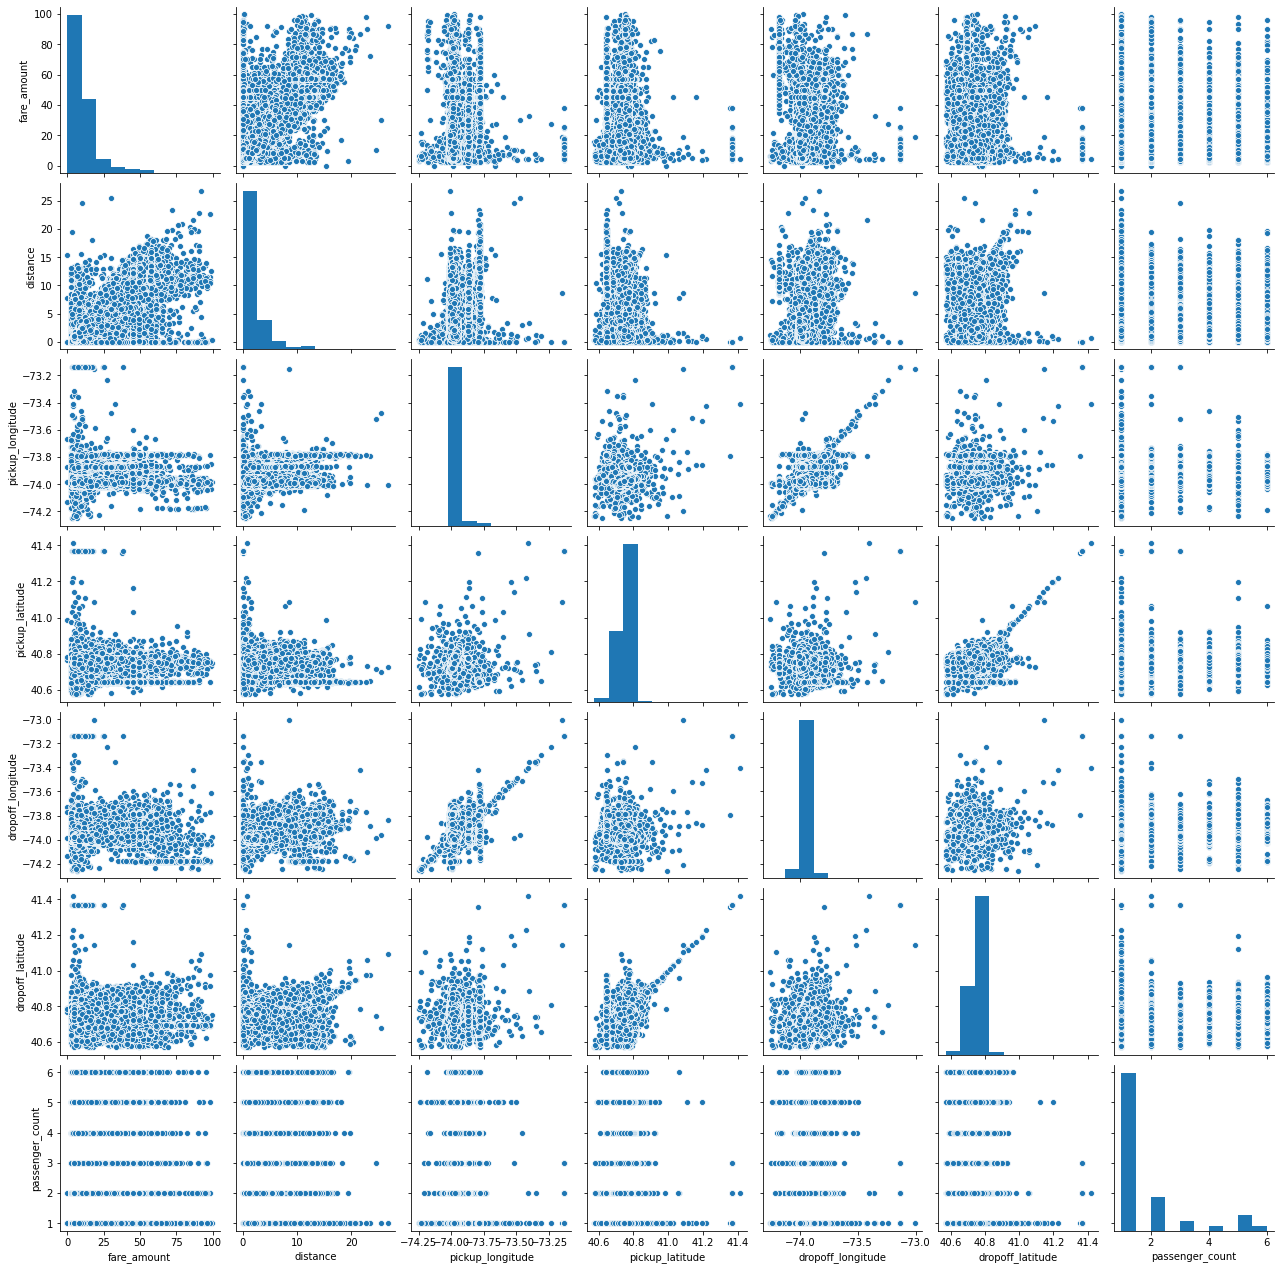

In [16]:
# Exploring the distributions of the continuous and their inter relationships

cols = ['fare_amount', 'distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
        'dropoff_latitude', 'passenger_count']
sns.pairplot (uber [cols]);

##### Inferences:
    1. There seems to be precence of multicollinearity between pickup and dropoff longitude and lattitude.
    2. We can see that there are some observations where distance = 0 which is quite unusual.
    3. The variables seems to be skewed and hence it might be a good idea to do transformations of these variables.
    4. Since, the variables are skewed therefore non-parametric models might be better for predicting the fare.

In [17]:
# Getting the data points where distance = 0

print ('************************************************ Train data ************************************************')
display (uber [uber.distance == 0])
print ('\n\n************************************************ Test data ************************************************')
display (uber_test [uber_test.distance == 0])

************************************************ Train data ************************************************


,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,weeknum,weekday,pickup_hour,month,year
23,2010-05-28 16:15:03.0000002,4.9,-73.992876,40.763102,-73.992876,40.763102,1,0.0,21,4,16,5,2010
72,2011-11-25 07:05:00.0000006,10.9,-73.966785,40.647952,-73.966785,40.647952,1,0.0,47,4,7,11,2011
153,2009-05-12 17:31:10.0000002,26.3,-73.975124,40.747875,-73.975124,40.747875,1,0.0,19,1,17,5,2009
406,2009-07-06 07:16:57.0000002,2.5,-73.932861,40.756935,-73.932861,40.756935,1,0.0,27,0,7,7,2009
541,2011-02-16 08:11:03.0000001,5.3,-73.976634,40.759150,-73.976634,40.759150,1,0.0,7,2,8,2,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276550,2010-05-30 03:56:15.0000004,6.1,-73.990484,40.746320,-73.990484,40.746320,1,0.0,21,6,3,5,2010
276608,2012-09-01 14:10:00.000000161,6.9,-73.994747,40.758320,-73.994747,40.758320,2,0.0,35,5,14,9,2012
276685,2013-05-09 19:33:56.0000005,5.5,-73.987771,40.738082,-73.987771,40.738082,1,0.0,18,3,19,5,2013
276704,2010-04-05 13:35:45.0000004,13.3,-73.958834,40.768222,-73.958834,40.768222,1,0.0,14,0,13,4,2010




************************************************ Test data ************************************************


,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,weeknum,weekday,pickup_hour,month,year
121,2014-06-14 13:39:00.000000191,-73.980590,40.747682,-73.980590,40.747682,1,0.0,23,5,13,6,2014
279,2010-09-05 22:31:32.0000002,-74.047394,40.785789,-74.047394,40.785789,1,0.0,35,6,22,9,2010
318,2009-06-10 16:55:00.000000131,-73.985862,40.744027,-73.985862,40.744027,1,0.0,23,2,16,6,2009
417,2011-06-24 12:03:00.000000145,-73.964615,40.777620,-73.964615,40.777620,1,0.0,25,4,12,6,2011
423,2011-06-24 12:03:00.00000086,-73.955065,40.771505,-73.955065,40.771505,1,0.0,25,4,12,6,2011
...,...,...,...,...,...,...,...,...,...,...,...,...
9478,2011-12-13 22:00:00.00000044,-73.946078,40.749467,-73.946078,40.749467,5,0.0,50,1,22,12,2011
9500,2014-07-21 18:19:00.00000025,-73.975767,40.752947,-73.975767,40.752947,5,0.0,29,0,18,7,2014
9563,2011-03-06 21:01:00.00000018,-73.990780,40.724202,-73.990780,40.724202,5,0.0,9,6,21,3,2011
9830,2014-07-21 18:19:00.00000065,-73.981425,40.773935,-73.981425,40.773935,6,0.0,29,0,18,7,2014


We can remove these data points as they are irrelevant.

In [18]:
# Selecting only the data points where distance > 0

uber = uber [uber.distance > 0]
uber_test = uber_test [uber_test.distance > 0]
print ('The shape of the resultant training data =', uber.shape)
print ('The shape of the resultant testing data =', uber_test.shape)

The shape of the resultant training data = (267282, 13)
The shape of the resultant testing data = (9826, 12)


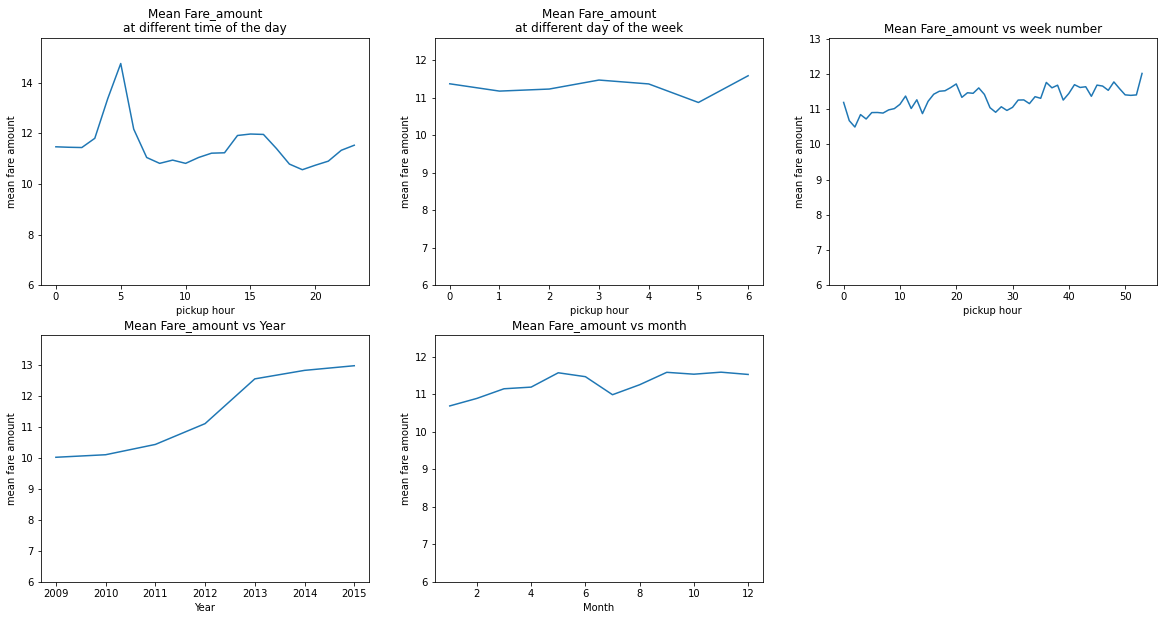

In [19]:
# Exploring the change in fare amount with time of the day, day of week, week number and year

plt.figure (figsize = (20,10))

plt.subplot (231)
df = uber.groupby ('pickup_hour').agg ({'fare_amount' : 'mean'})
plt.plot (df.index, df.fare_amount)
plt.ylim ([6, df.fare_amount.max ()+1])
plt.xlabel ('pickup hour')
plt.ylabel ('mean fare amount')
plt.title ('Mean Fare_amount\nat different time of the day')
#sns.boxplot (uber.pickup_hour, uber.fare_amount)

plt.subplot (232)
df = uber.groupby ('weekday').agg ({'fare_amount' : 'mean'})
plt.plot (df.index, df.fare_amount)
plt.ylim ([6, df.fare_amount.max ()+1])
plt.xlabel ('day of the week')
plt.ylabel ('mean fare amount')
plt.title ('Mean Fare_amount\nat different day of the week')
#sns.boxplot (uber.weekday, uber.fare_amount)

plt.subplot (233)
df = uber.groupby ('weeknum').agg ({'fare_amount' : 'mean'})
plt.plot (df.index, df.fare_amount)
plt.ylim ([6, df.fare_amount.max ()+1])
plt.xlabel ('week number')
plt.ylabel ('mean fare amount')
plt.title ('Mean Fare_amount vs week number')
#sns.boxplot (uber.weeknum, uber.fare_amount);

plt.subplot (234)
df = uber.groupby ('year').agg ({'fare_amount' : 'mean'})
plt.plot (df.index, df.fare_amount)
plt.ylim ([6, df.fare_amount.max ()+1])
plt.xlabel ('Year')
plt.ylabel ('mean fare amount')
plt.title ('Mean Fare_amount vs Year')

plt.subplot (235)
df = uber.groupby ('month').agg ({'fare_amount' : 'mean'})
plt.plot (df.index, df.fare_amount)
plt.ylim ([6, df.fare_amount.max ()+1])
plt.xlabel ('Month')
plt.ylabel ('mean fare amount')
plt.title ('Mean Fare_amount vs month');

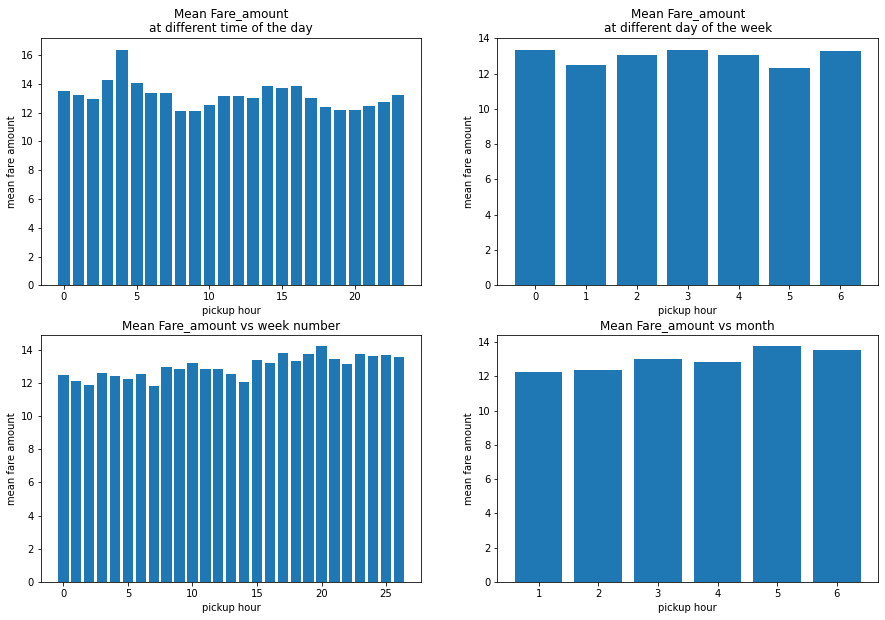

In [20]:
# Exploring the change in fare amount with time of the day, day of week and week number for year 2015

plt.figure (figsize = (15,10))

plt.subplot (221)
df = uber [uber.year == 2015].groupby ('pickup_hour').agg ({'fare_amount' : 'mean'})
plt.bar (df.index, df.fare_amount)
plt.xlabel ('pickup hour')
plt.ylabel ('mean fare amount')
plt.title ('Mean Fare_amount\nat different time of the day')

plt.subplot (222)
df = uber [uber.year == 2015].groupby ('weekday').agg ({'fare_amount' : 'mean'})
plt.bar (df.index, df.fare_amount)
plt.xlabel ('day of the week')
plt.ylabel ('mean fare amount')
plt.title ('Mean Fare_amount\nat different day of the week')

plt.subplot (223)
df = uber [uber.year == 2015].groupby ('weeknum').agg ({'fare_amount' : 'mean'})
plt.bar (df.index, df.fare_amount)
plt.xlabel ('week number')
plt.ylabel ('mean fare amount')
plt.title ('Mean Fare_amount vs week number')

plt.subplot (224)
df = uber [uber.year == 2015].groupby ('month').agg ({'fare_amount' : 'mean'})
plt.bar (df.index, df.fare_amount)
plt.xlabel ('month')
plt.ylabel ('mean fare amount')
plt.title ('Mean Fare_amount vs month');

##### Inferences:
    1. There is very less variation in the mean fare_amount due to time of the day and week of the day.
    2. But there is some difference in the mean fare_amount during certain weeks.
    3. Also, the mean fare amount has been increasing over the years.

c:\python\python38\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\python\python38\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\python\python38\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\python\python38\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\python\python38\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


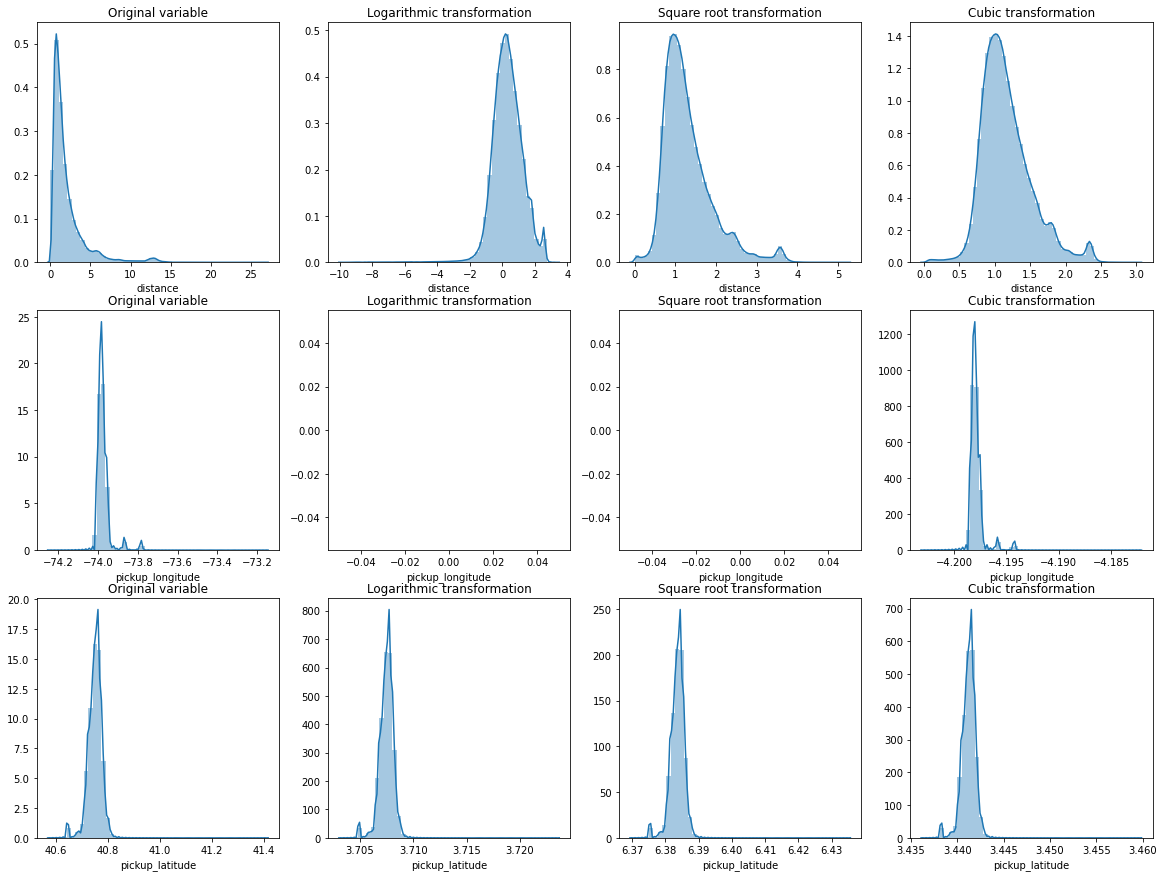

In [21]:
# Exploring the options of variable transformations

i = 1
plt.figure (figsize = (20,15))

for col in ['distance', 'pickup_longitude', 'pickup_latitude'] :
    
    plt.subplot (3,4,i)
    sns.distplot (uber [col])
    plt.title ('Original variable')
    
    i += 1
    plt.subplot (3,4,i)
    sns.distplot (np.log (uber [col]))
    plt.title ('Logarithmic transformation')
    
    i += 1
    plt.subplot (3,4,i)
    sns.distplot (np.sqrt (uber [col]))
    plt.title ('Square root transformation')
    
    i += 1
    plt.subplot (3,4,i)
    sns.distplot (np.cbrt (uber [col]))
    plt.title ('Cubic transformation');
    
    i +=1

##### Cubic transformation of distance variable leads to an approximately normal distribution. For all other variables transformations are not useful.

In [22]:
# Performing cubic transformation of distance variable

uber.distance = np.cbrt (uber.distance)
uber_test.distance = np.cbrt (uber_test.distance)

In [23]:
# Removing the key column

uber.drop (columns = 'key', inplace = True)
uber_test.drop (columns = 'key', inplace = True)

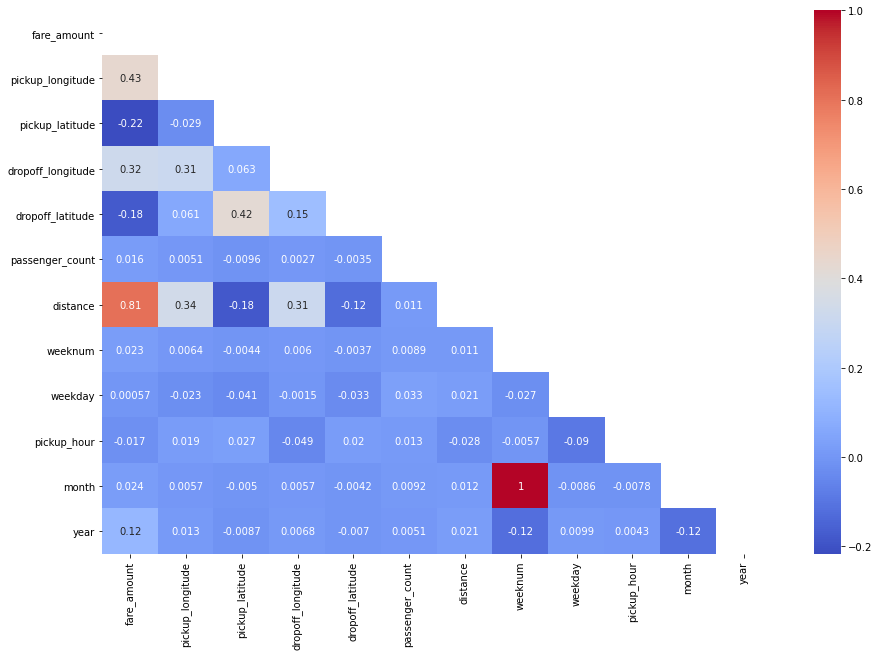

In [24]:
# Let's check the correlation matrix

mask = np.triu (np.ones ((uber.shape[1], uber.shape [1])))
plt.figure (figsize=(15,10))
sns.heatmap (uber.corr (), annot = True, mask = mask, cmap = 'coolwarm');

In [25]:
# Obtaining X and y variables

X = uber.drop (columns = 'fare_amount')
y = uber.fare_amount

In [26]:
# Performing simple train test split

X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.75, random_state = 23)
print ('The shape of the train data =', X_train.shape, y_train.shape)
print ('The shape of the test data =', X_test.shape, y_test.shape)

The shape of the train data = (200461, 11) (200461,)
The shape of the test data = (66821, 11) (66821,)


In [27]:
# Combining X and y variables for use in ols model

u_train = pd.concat ([X_train, y_train], axis = 1)
print ('The shape of the train data =', u_train.shape)

The shape of the train data = (200461, 12)


In [28]:
# Building the Linear Regression model

formula = "fare_amount ~ " + " + ".join (X_train.columns)
olsmodel = ols (formula, data = u_train).fit ()
olsmodel.summary ()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                 4.323e+04
Date:                Mon, 17 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:59:49   Log-Likelihood:            -6.1036e+05
No. Observations:              200461   AIC:                         1.221e+06
Df Residuals:                  200449   BIC:                         1.221e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5452.2804     43.517    125.290      0.000    5366.987    5537.574
pickup_longitude     48.6562      0.358    136.038      0.000      47.955      49.357
pickup_latitude     -16.6471      0.471    -35.343      0.000     -17.570     -15.724
dropoff_longitude    15.6350      0.364     42.950      0.000      14.921      16.348
dropoff_latitude    -26.3452      0.412    -63.884      0.000     -27.154     -25.537
passenger_count       0.0463      0.009      5.345      0.000       0.029       0.063
distance             18.5936      0.036    515.933      0.000      18.523      18.664
weeknum              -0.0386      0.009     -4.299      0.000      -0.056      -0.021
weekday              -0.0821      0.006    -13.706      0.000      -0.094      -0.070
pickup_hour           0.0041      0.002      2.325      0.020       0.001       0.008
month                 0.2420      0.039      6.193      0.000       0.165       0.319
year                  0.5193      0.006     84.567      0.000       0.507       0.531
==============================================================================
Omnibus:                   190702.401   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18601362.009
Skew:                           4.359   Prob(JB):                         0.00
Kurtosis:                      49.379   Cond. No.                     7.73e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.73e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### The high value of condition number shows presence of multicollinearity.

In [29]:
# Checking the VIF values for each column

def vif_func (X_vif) :
    vif = pd.DataFrame ()
    vif ['columns'] = X_vif.columns
    vif ['vif_values'] = [VIF (X_vif.values, i) for i in range (X_vif.columns.size)]
    return (vif.T)

vif_func (X.drop (columns = ['weekday', 'weeknum', 'passenger_count']))

,0,1,2,3,4,5,6,7
columns,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,pickup_hour,month,year
vif_values,4.12501e+06,2.58647e+06,3.82939e+06,1.9372e+06,12.3121,5.31553,4.38129,1.0785e+06


##### Since there are presence of multicollinearity, we use regularization techniques to see if we can get better results with linear regression.

In [30]:
grid_ridge = GridSearchCV (estimator = Ridge (normalize = True),
                           param_grid = {'alpha' : np.logspace (-5, 3, 50)},
                           cv = 3,
                           scoring = 'r2').fit (X, y)

print ('The best score with Ridge regression is ', grid_ridge.best_score_)
print ('The best parameters with Ridge regression are ', grid_ridge.best_params_)

The best score with Ridge regression is  0.7040745001909056
The best parameters with Ridge regression are  {'alpha': 0.00029470517025518097}


In [31]:
grid_lasso = GridSearchCV (estimator = Lasso (normalize = True),
                           param_grid = {'alpha' : np.logspace (-5, 3, 50)},
                           cv = 3,
                           scoring = 'r2').fit (X, y)

print ('The best score with Lasso regression is ', grid_lasso.best_score_)
print ('The best parameters with Lasso regression are ', grid_lasso.best_params_)

The best score with Lasso regression is  0.7040530189346269
The best parameters with Lasso regression are  {'alpha': 1e-05}


##### Inferences:
    1. The alpha value chosen is on the lower side which means that there is 
       negligible effect of the regularization term and essentially the model considered is 
       close to basic linear regression model.
    2. Though, we see that there is high multicollinearity between variables but these variables are important.
    3. We can try non-parametric regression models for this data set to get better results.

In [32]:
# RMSE value with the linear regression

print ('The RMSE value with the linear regression model =',
       mse (y_test, olsmodel.predict (X_test), squared = False))

The RMSE value with the linear regression model = 5.025533215002505


##### To try RandomForest, we first need to tune the model for max_depth and max_features to obtain best results.

In [33]:
# Tuning for best value of max_depth

scores_list = []
mean_scores = []
depth_values = [5,10,20,30,40,50]

for max_depth in depth_values :
    
    print ('\n\nTraining the model for max_depth = {} ...'.format (max_depth))
    
    rf = RandomForestRegressor (n_estimators = 100, 
                                max_depth = max_depth, 
                                n_jobs = 2,
                                random_state = 23)
    
    score = cross_val_score (estimator = rf, X = X, y = y, cv = 5, scoring = 'r2')
    
    print ('Training is complete for max_depth =', max_depth)
    
    scores_list.append (score)
    mean_scores.append (score.mean())
    
    print ('\nFor max_depth = {}, mean R2 score = {}, Std = {}'.format (max_depth,
                                                                        score.mean (),
                                                                        score.std ()))

best_score = np.max (mean_scores)
best_max_depth = depth_values [np.argmax (mean_scores)]
print ('\n\n ****************************Cross Validation Complete****************************')
print ('\n The best mean R2 score of {} is obtained at max_depth of {}'.format (best_score,
                                                                                best_max_depth))



Training the model for max_depth = 5 ...
Training is complete for max_depth = 5

For max_depth = 5, mean R2 score = 0.8322432530639254, Std = 0.005405589981617603


Training the model for max_depth = 10 ...
Training is complete for max_depth = 10

For max_depth = 10, mean R2 score = 0.8593804207483797, Std = 0.005773813100569279


Training the model for max_depth = 20 ...
Training is complete for max_depth = 20

For max_depth = 20, mean R2 score = 0.8673471007467587, Std = 0.006117321791748101


Training the model for max_depth = 30 ...
Training is complete for max_depth = 30

For max_depth = 30, mean R2 score = 0.8679127844305929, Std = 0.00591410914822575


Training the model for max_depth = 40 ...
Training is complete for max_depth = 40

For max_depth = 40, mean R2 score = 0.8678467477488221, Std = 0.0059704404060605875


Training the model for max_depth = 50 ...
Training is complete for max_depth = 50

For max_depth = 50, mean R2 score = 0.8678621494041823, Std = 0.00604579627875

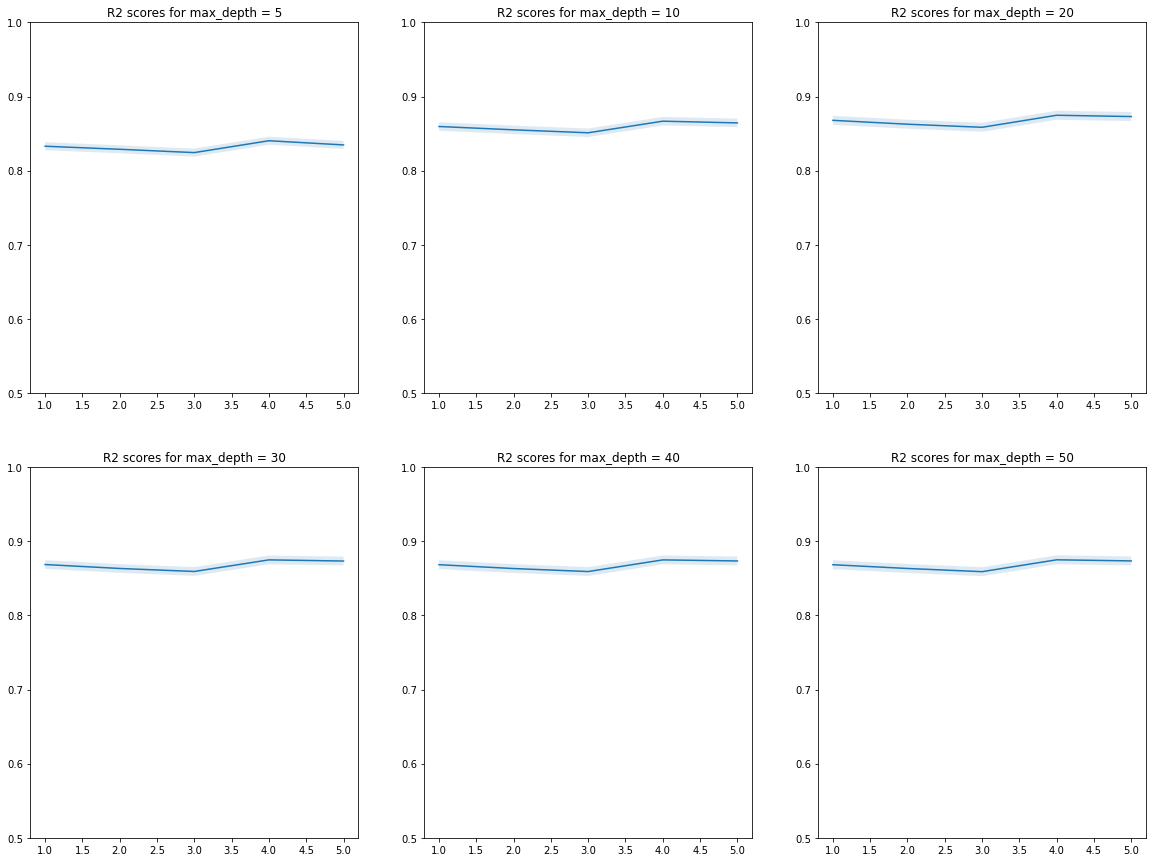

In [34]:
# Plotting the R2 scores for each max_depth

i=1
plt.figure (figsize = (20,15))

for depth, scores in zip (depth_values, scores_list) :
    
    # Setting subplots for R2 scores
    plt.subplot (2,3,i)
    plt.ylim (0.5,1)
    plt.title ('R2 scores for max_depth = {}'.format (depth))
    i+=1
    
    # Plotting R2 scores
    plt.plot (range (1, len (scores) + 1), scores)
    upperval = scores + scores.std()
    lowerval = scores - scores.std()
    plt.fill_between (range (1, len (scores) + 1), upperval, lowerval, alpha = 0.15)
    
plt.show ()

##### Inferences:
    1. We get the best results at max_depth = 30.
    2. The model is a low variance model and we can expect it to perform well on the unseen data.


Training the model for max_features = 1 ...
Training is complete for max_features = 1
For max_features = 1, train_score = 0.9749704227090812, oob_score = 0.8487207438394614

Training the model for max_features = 2 ...
Training is complete for max_features = 2
For max_features = 2, train_score = 0.9787118764975443, oob_score = 0.8708208586231146

Training the model for max_features = 3 ...
Training is complete for max_features = 3
For max_features = 3, train_score = 0.9803290574676787, oob_score = 0.8744260909173099

Training the model for max_features = 4 ...
Training is complete for max_features = 4
For max_features = 4, train_score = 0.9811372517201856, oob_score = 0.8746745640426339

Training the model for max_features = 5 ...
Training is complete for max_features = 5
For max_features = 5, train_score = 0.9813060934292425, oob_score = 0.8731316888705963

Training the model for max_features = 6 ...
Training is complete for max_features = 6
For max_features = 6, train_score = 0.98145

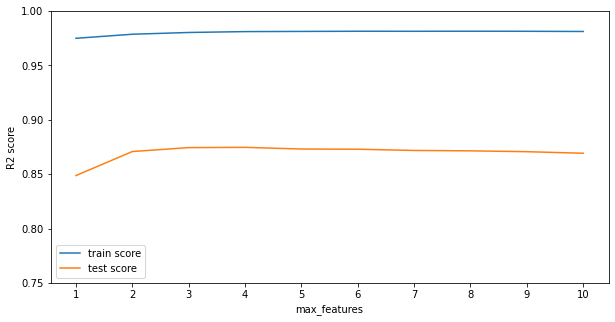

In [35]:
# Tuning for best value of max_features

train_score = []
oob_score = []
max_features_values = range (1, X.shape [1], 1)

for max_features in max_features_values :
    
    print ('\nTraining the model for max_features = {} ...'.format (max_features))
    rf = RandomForestRegressor (n_estimators = 100, 
                                max_features = max_features,
                                max_depth = best_max_depth,
                                n_jobs = 2, 
                                oob_score = True,
                                random_state = 23).fit (X, y)
    
    print ('Training is complete for max_features =', max_features)
    train_score.append (rf.score (X, y))
    oob_score. append (rf.oob_score_)
    print ('For max_features = {}, train_score = {}, oob_score = {}'.format (max_features,
                                                                             train_score [-1],
                                                                             oob_score [-1]))

best_oob_score = np.max (oob_score)
best_max_features = max_features_values [np.argmax (oob_score)]
print ('\n\nThe best oob score of {} is obtained at max_features = {}'.format (best_oob_score,
                                                                               best_max_features))

plt.figure (figsize = (10,5))
plt.plot (max_features_values, train_score, label = 'train score')
plt.plot (max_features_values, oob_score, label = 'test score')
plt.xlabel ('max_features')
plt.ylabel ('R2 score')
plt.ylim (.75, 1)
plt.xticks (max_features_values)
plt.legend ()
plt.show ()

##### Looks like the best value of max_features is 4.

##### Let's check K-Nearest Regressor

Training the model for n_neighbors = 3 ...
Training is complete for n_neighbors = 3
For n_neighbors = 3, train_score = 0.8805840865058631, test_score = 0.7534893019667253
Training the model for n_neighbors = 5 ...
Training is complete for n_neighbors = 5
For n_neighbors = 5, train_score = 0.846745137581657, test_score = 0.7646771534651748
Training the model for n_neighbors = 7 ...
Training is complete for n_neighbors = 7
For n_neighbors = 7, train_score = 0.8280332988055794, test_score = 0.7659903637007266
Training the model for n_neighbors = 9 ...
Training is complete for n_neighbors = 9
For n_neighbors = 9, train_score = 0.8143417773731514, test_score = 0.7644245352175825
Training the model for n_neighbors = 11 ...
Training is complete for n_neighbors = 11
For n_neighbors = 11, train_score = 0.8044055989302059, test_score = 0.7626005782761202
Training the model for n_neighbors = 13 ...
Training is complete for n_neighbors = 13
For n_neighbors = 13, train_score = 0.7959659644293089, t

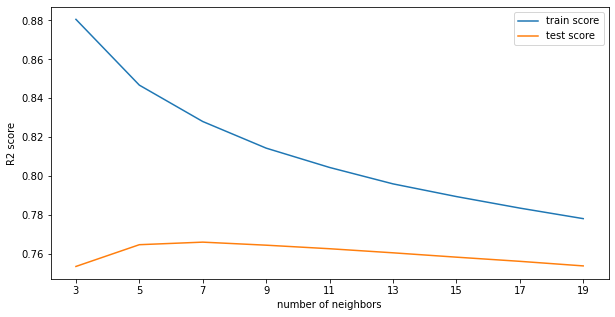

In [36]:
# Normalizing the X Variables

from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler ()
X_train_sc = mm.fit_transform (X_train)
X_test_sc = mm.transform (X_test)

# Tuning for best value of n_neighbors

train_score = []
test_score = []
n_values = range (3, 20, 2)

for n_neighbors in n_values :
    
    print ('Training the model for n_neighbors = {} ...'.format (n_neighbors))
    knr = KNeighborsRegressor (n_neighbors = n_neighbors,
                               n_jobs = 2).fit (X_train_sc, y_train)
    
    print ('Training is complete for n_neighbors =', n_neighbors)
    train_score.append (knr.score (X_train_sc, y_train))
    test_score.append (knr.score (X_test_sc, y_test))
    print ('For n_neighbors = {}, train_score = {}, test_score = {}'.format (n_neighbors,
                                                                             train_score [-1],
                                                                             test_score [-1]))

plt.figure (figsize = (10,5))
plt.plot (n_values, train_score, label = 'train score')
plt.plot (n_values, test_score, label = 'test score')
plt.xlabel ('number of neighbors')
plt.ylabel ('R2 score')
plt.xticks ([val for val in n_values])
plt.legend ()
plt.show ()

##### Seems like Random forest Regressor performs better on this data set. Lets check the performance of the model on the train and test split performed earlier. For better results, we can increase the n_estimators to 200 as anything above that will not get executed on this laptop.

In [37]:
# Checking the performance on train-test split data

rf_final = RandomForestRegressor (n_estimators = 200,
                                  max_depth = 30,
                                  max_features = 4,
                                  n_jobs = 2,
                                  random_state = 23).fit (X_train, y_train)

ypred = rf_final.predict (X_test)
print ('The R2 score (train) =', rf_final.score (X_train, y_train))
print ('The R2 score (test) =', rf_final.score (X_test, y_test))
print ('The RMSE value =', mse (y_test, ypred, squared = False))
print ('MAPE =', np.abs ((y_test -ypred)/y_test).mean () *100)
print ('MPE =', ((y_test -ypred)/y_test).mean () *100)

The R2 score (train) = 0.9816210495653308
The R2 score (test) = 0.8753342468364239
The RMSE value = 3.2726215168378086
MAPE = 25.677886437226434
MPE = -15.48406299111237


In [38]:
# Checking for Cross validation scores

print ('Performing 10-Fold Cross validation on the selected model\n')

rf_final = RandomForestRegressor (n_estimators = 200,
                                  max_depth = 30,
                                  max_features = 4,
                                  n_jobs = 2,
                                  random_state = 23)

count = 0

def mape (y_true, ypred) :
    return (np.abs ((y_true -ypred)/y_true).mean () *100)

def mpe (y_true, ypred) :
    global count
    count += 1
    if count % 2 == 0 :
        print ('Fold #{} completed out of 10-Folds'.format (int (count/2)))
    return (((y_true -ypred)/y_true).mean () *100)

scores = cross_validate (estimator = rf_final,
                         X = X,
                         y = y,
                         cv = 10,
                         scoring = {'R2' : 'r2',
                                    'RMSE' : 'neg_root_mean_squared_error',
                                    'MAE' : 'neg_mean_absolute_error',
                                    'MAPE' : make_scorer (mape, greater_is_better=False),
                                    'MPE' : make_scorer (mpe, greater_is_better=False)},
                         return_train_score = True)
    
print ('\nCross validation is complete for the selected model,\nAnd the CV results are :')
scores = pd.DataFrame (scores)
display (scores)
    
print ('\nThe RMSE value is, mean = {}, std = {}'.format (scores ['test_RMSE'].mean(),
                                                          scores ['test_RMSE'].std ()))
print ('\nThe R2 value is, mean = {}, std = {}'.format (scores ['test_R2'].mean(),
                                                        scores ['test_R2'].std ()))
print ('\nThe MAPE value is, mean = {}, std = {}'.format (scores ['test_MAPE'].mean(),
                                                          scores ['test_MAPE'].std ()))
print ('\nThe MPE value is, mean = {}, std = {}'.format (scores ['test_MPE'].mean(),
                                                          scores ['test_MPE'].std ()))
print ('\nThe MAE value is, mean = {}, std = {}'.format (scores ['test_MAE'].mean(),
                                                         scores ['test_MAE'].std ()))

Performing 10-Fold Cross validation on the selected model

Fold #1 completed out of 10-Folds
Fold #2 completed out of 10-Folds
Fold #3 completed out of 10-Folds
Fold #4 completed out of 10-Folds
Fold #5 completed out of 10-Folds
Fold #6 completed out of 10-Folds
Fold #7 completed out of 10-Folds
Fold #8 completed out of 10-Folds
Fold #9 completed out of 10-Folds
Fold #10 completed out of 10-Folds

Cross validation is complete for the selected model,
And the CV results are :


,fit_time,score_time,test_R2,train_R2,test_RMSE,train_RMSE,test_MAE,train_MAE,test_MAPE,train_MAPE,test_MPE,train_MPE
0,232.015770,1.520810,0.868274,0.981526,-3.426182,-1.264602,-1.691000,-0.687233,-34.075114,-9.544614,23.678688,4.980625
1,216.385334,1.792673,0.885288,0.981274,-3.181999,-1.273910,-1.649461,-0.691181,-17.382235,-10.289503,7.140462,5.704607
2,216.349467,2.469116,0.874219,0.981417,-3.295069,-1.270607,-1.675039,-0.691015,-17.735368,-9.998257,7.514407,5.403980
3,218.270725,3.355385,0.871345,0.981477,-3.338609,-1.268283,-1.676753,-0.690154,-39.978629,-9.078537,29.841908,4.497036
4,225.204750,1.300108,0.865209,0.981674,-3.533852,-1.256644,-1.717542,-0.685126,-31.342607,-9.031736,21.133752,4.486859
5,215.754054,2.487848,0.870368,0.981719,-3.314042,-1.261538,-1.674317,-0.685139,-17.539525,-10.123953,7.163721,5.583891
6,236.718574,1.391491,0.878249,0.981575,-3.220557,-1.266112,-1.651387,-0.685386,-17.362501,-10.023770,7.202570,5.510343
7,218.567586,2.376703,0.886232,0.981453,-3.101088,-1.270816,-1.637227,-0.687202,-17.217781,-10.126143,7.242656,5.590860
8,220.925061,5.770320,0.874909,0.981421,-3.320238,-1.268995,-1.688590,-0.691548,-17.789905,-10.123561,7.504125,5.524315
9,224.694722,1.733921,0.887674,0.981292,-3.045978,-1.277878,-1.624272,-0.692138,-17.556524,-10.161981,7.633093,5.585748



The RMSE value is, mean = -3.27776134325615, std = 0.1461024134528999

The R2 value is, mean = 0.8761765893611827, std = 0.007929189791037378

The MAPE value is, mean = -22.798018927576827, std = 8.763608545112225

The MPE value is, mean = 12.605538160746992, std = 8.733967870350066

The MAE value is, mean = -1.6685588329184236, std = 0.02798634506429133


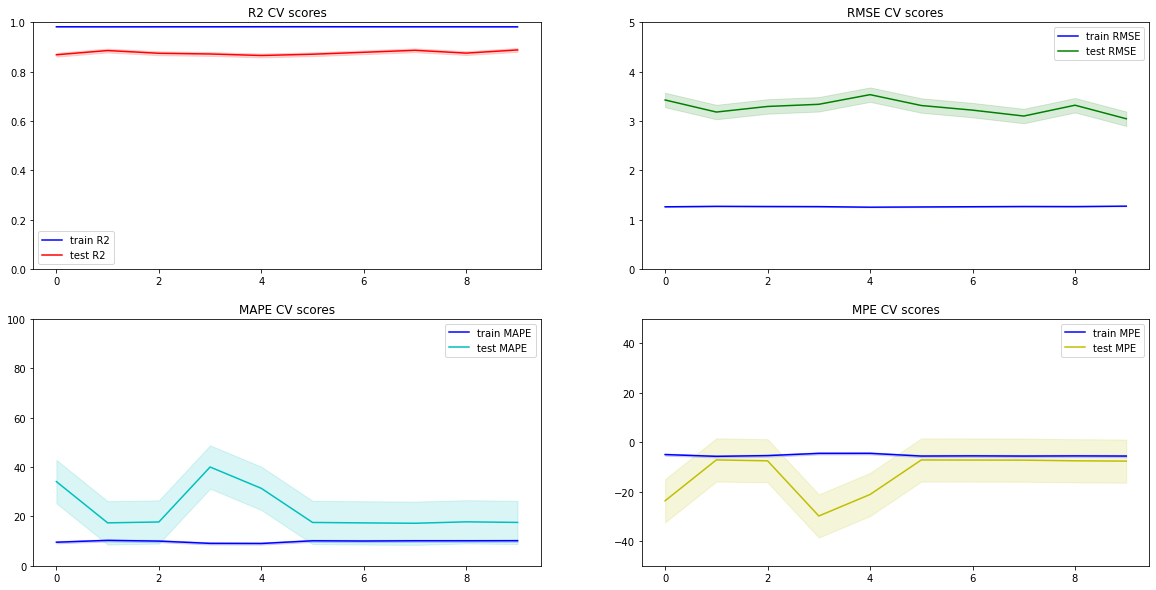

In [39]:
# Plotting the CV results

plt.figure (figsize = (20, 10))

# Setting subplots for R2 scores
plt.subplot (2,2,1)
plt.ylim (0, 1)
plt.title ('R2 CV scores')
    
# Plotting train R2 scores
plt.plot (range (10), scores.train_R2, color = 'b', label = 'train R2')
upperval = scores.train_R2 + scores.train_R2.std()
lowerval = scores.train_R2 - scores.train_R2.std()
plt.fill_between (range (10), upperval, lowerval, color = 'b', alpha = 0.15)
    
# Plotting test R2 scores
plt.plot (range (10), scores.test_R2, color = 'r', label = 'test R2')
upperval = scores.test_R2 + scores.test_R2.std()
lowerval = scores.test_R2 - scores.test_R2.std()
plt.fill_between (range (10), upperval, lowerval, color = 'r', alpha = 0.15)

plt.legend ()
    
# Setting subplots for RMSE scores
plt.subplot (2,2,2)
plt.ylim (0, 5)
plt.title ('RMSE CV scores')
    
# Plotting train RMSE scores
RMSE_train = scores.train_RMSE * -1
plt.plot (range (10), RMSE_train, color = 'b', label = 'train RMSE')
upperval = RMSE_train + RMSE_train.std()
lowerval = RMSE_train - RMSE_train.std()
plt.fill_between (range (10), upperval, lowerval, color = 'b', alpha = 0.15)
    
# Plotting test RMSE scores
RMSE_test = scores.test_RMSE * -1
plt.plot (range (10), RMSE_test, color = 'g', label = 'test RMSE')
upperval = RMSE_test + RMSE_test.std()
lowerval = RMSE_test - RMSE_test.std()
plt.fill_between (range (10), upperval, lowerval, color = 'g', alpha = 0.15)

plt.legend ()
    
# Setting subplots for MAPE scores
plt.subplot (2,2,3)
plt.ylim (0, 100)
plt.title ('MAPE CV scores')
    
# Plotting train MAPE scores
MAPE_train = scores.train_MAPE * -1
plt.plot (range (10), MAPE_train, color = 'b', label = 'train MAPE')
upperval = MAPE_train + MAPE_train.std()
lowerval = MAPE_train - MAPE_train.std()
plt.fill_between (range (10), upperval, lowerval, color = 'b', alpha = 0.15)
    
# Plotting test MAPE scores
MAPE_test = scores.test_MAPE * -1
plt.plot (range (10), MAPE_test, color = 'c', label = 'test MAPE')
upperval = MAPE_test + MAPE_test.std()
lowerval = MAPE_test - MAPE_test.std()
plt.fill_between (range (10), upperval, lowerval, color = 'c', alpha = 0.15)

plt.legend ()

# Setting subplots for MPE scores
plt.subplot (2,2,4)
plt.ylim (-50, 50)
plt.title ('MPE CV scores')
    
# Plotting train MPE scores
MPE_train = scores.train_MPE * -1
plt.plot (range (10), MPE_train, color = 'b', label = 'train MPE')
upperval = MPE_train + MPE_train.std()
lowerval = MPE_train - MPE_train.std()
plt.fill_between (range (10), upperval, lowerval, color = 'b', alpha = 0.15)
    
# Plotting test MPE scores
MPE_test = scores.test_MPE * -1
plt.plot (range (10), MPE_test, color = 'y', label = 'test MPE')
upperval = MPE_test + MPE_test.std()
lowerval = MPE_test - MPE_test.std()
plt.fill_between (range (10), upperval, lowerval, color = 'y', alpha = 0.15)

plt.legend ()

plt.show ()

##### The CV results quite satisfactory. The model is low bias and low variance, we can now use this as final model to make predictions on the test data.

In [40]:
# Fitting the model on the train data

rf_final.fit (X, y)

# Making predictions on the testing data

ypred_test = rf_final.predict (uber_test)

# Adding the predictions to the testing data

uber_test ['fare_amount'] = ypred_test

# Displaying the first 10 rows of the testing data

display (uber_test.head (10))

# Saving the testing data to a new file

uber_test.to_csv (r'H:\Documents\Study material\Data Science course\Machine Learning\Main projects\Practice Project 1 - Uber Fare Prediction\test_pred.csv',
                  index = False)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,weeknum,weekday,pickup_hour,month,year,fare_amount
0,-73.973320,40.763805,-73.981430,40.743835,1,1.129817,4,1,13,1,2015,10.297752
1,-73.986862,40.719383,-73.998886,40.739201,1,1.146259,4,1,13,1,2015,10.579154
2,-73.982524,40.751260,-73.979654,40.746139,1,0.726924,40,5,11,10,2011,4.390873
3,-73.981160,40.767807,-73.990448,40.751635,1,1.067853,48,5,21,12,2012,8.396879
4,-73.966046,40.789775,-73.988565,40.744427,1,1.495503,48,5,21,12,2012,16.871523
5,-73.960983,40.765547,-73.979177,40.740053,1,1.260241,48,5,21,12,2012,11.940500
6,-73.949013,40.773204,-73.959622,40.770893,1,0.833443,40,3,12,10,2011,4.910805
7,-73.777282,40.646636,-73.985083,40.759368,1,2.375267,40,3,12,10,2011,48.970494
8,-74.014099,40.709638,-73.995106,40.741365,1,1.339905,40,3,12,10,2011,11.068780
9,-73.969582,40.765519,-73.980686,40.770725,1,0.881256,7,1,15,2,2014,6.184802


##### Project completed by: Sahaj Harnal
##### Email: sahajharnal@gmail.com